# Класс Matrix (из предыдущей лабораторной работы)

Создан класс разреженной матрицы Matrix.
* В конструкторе задаются размеры и структуры хранения.
* Метод AddElement добавляет ненулевой элемент в разреженную структуру.
* GetElement и ToRegularMatrix обеспечивают доступ к полному виду матрицы.
* Transpose и Dot выполняют транспонирование и умножение матриц.
* NormalizeVector нормализует вектор по L2-норме.
* Determinant вычисляет определитель через модифицированный метод Гаусса.

In [40]:
import copy
from typing import List

class Matrix:
    def __init__(self, rows: int, cols: int):
        self.rows = rows
        self.cols = cols
        self.data = list()
        self.columns = list()
        self.row_ptr = [0]

# добавляем ненулевое значение в нужную ячейку
    def AddElement(self,row: int,col: int, value : float):
        if (row >= self.rows or col >= self.cols): #Проверка границ строки и столбца
            assert False
        #Поддержка корректной длины row_ptr
        while(len(self.row_ptr) != (row + 2)):
            self.row_ptr.append(self.row_ptr[len(self.row_ptr) - 1])
        #Добавление ненулевых элементов
        if (value != 0):
            self.data.append(value)
            self.columns.append(col)
            self.row_ptr[row+1] += 1

    def GetElement(self,row: int,col: int):
        #Проверка границ строки и столбца
        if (row >= self.rows or col >= self.cols):
            assert False
        start = self.row_ptr[row]
        end = self.row_ptr[row +1]
        #Поиск запрашиваемого элемента
        for i in range(start,end):
            if (self.columns[i] == col):
                value = self.data[i]
                if (int(value) == value):
                    return int(value)
                return value
        #Если элемент не найден
        return 0

    @staticmethod
    def from_csr(rows: int, cols: int, data: list, columns: list, row_ptr: list) -> 'Matrix':
        mat = Matrix(rows, cols)
        mat.data = data
        mat.columns = columns
        mat.row_ptr = row_ptr
        return mat

    @staticmethod
    def from_list(data: List[List[float]]) -> 'Matrix':
        rows, cols = len(data), len(data[0])
        mat = Matrix(rows, cols)
        for r in range(rows):
            for c in range(cols):
                mat.AddElement(r, c, data[r][c])
        return mat


    def Transpose(self) -> 'Matrix':
        result = Matrix(self.cols, self.rows)  # Меняем местами строки и столбцы

        for i in range(self.rows):
            for idx in range(self.row_ptr[i], self.row_ptr[i + 1]):
                col = self.columns[idx]
                val = self.data[idx]
                result.AddElement(col, i, val)

        return result


    def swap_rows_(self,data,col,row_ptr, row1, row2):

        row1_start, row1_end = row_ptr[row1], row_ptr[row1 + 1]
        row2_start, row2_end = row_ptr[row2], row_ptr[row2 + 1]

        row1_data = data[row1_start:row1_end]
        row1_col = col[row1_start:row1_end]
        row2_data = data[row2_start:row2_end]
        row2_col = col[row2_start:row2_end]

        new_data = []
        new_indices = []
        new_row_ptr = [0]

        # перебираем все строки
        for i in range(self.rows):
            if i == row1:
                new_data.extend(row2_data)
                new_indices.extend(row2_col)
            elif i == row2:
                new_data.extend(row1_data)
                new_indices.extend(row1_col)
            else:
                start, end = row_ptr[i], row_ptr[i + 1]
                new_data.extend(data[start:end])
                new_indices.extend(col[start:end])


            new_row_ptr.append(len(new_data))
        return new_data,new_indices,new_row_ptr


    def ToRegularMatrix(self):
        matrix = [[0] * self.cols for _ in range(self.rows)]
        for i in range(self.rows):

            start = self.row_ptr[i]
            end = self.row_ptr[i + 1]
            for j in range(start, end):
                matrix[i][self.columns[j]] = self.data[j]
        return matrix

    # транспонирование
    def Transpose(self) -> 'Matrix':
        result = Matrix(self.cols, self.rows)
        for i in range(self.rows):
            for j in range(self.row_ptr[i], self.row_ptr[i + 1]):
                col = self.columns[j]
                val = self.data[j]
                result.AddElement(col, i, val)
        return result

    #умножение матриц
    def Dot(self, other: 'Matrix') -> 'Matrix':
        if self.cols != other.rows:
            raise ValueError("Несовместимые размеры для умножения")
        result = Matrix(self.rows, other.cols)
        B = other.ToRegularMatrix()
        for i in range(self.rows):
            row_vec = [0] * self.cols
            for j in range(self.row_ptr[i], self.row_ptr[i + 1]):
                row_vec[self.columns[j]] = self.data[j]
            for col in range(other.cols):
                dot = sum(row_vec[k] * B[k][col] for k in range(self.cols))
                if abs(dot) > 1e-12:
                    result.AddElement(i, col, dot)
        return result

    # нормализация вектора
    def NormalizeVector(vec: 'Matrix') -> 'Matrix':
        norm = math.sqrt(sum(vec.GetElement(i, 0)**2 for i in range(vec.rows)))
        if norm == 0:
            return vec
        result = Matrix(vec.rows, 1)
        for i in range(vec.rows):
            result.AddElement(i, 0, vec.GetElement(i, 0) / norm)
        return result

    def Determinant(self):
        if self.rows != self.cols:
            raise ValueError("Матрица должна быть квадратной")

        n = self.rows
        diag = [0] * n  # Диагональные элементы


        # Копируем исходные данные для изменения
        tmp_data = self.data[:]
        tmp_columns = self.columns[:]
        tmp_row_ptr = self.row_ptr[:]


        sign = 1


        for i in range(n):
            # Поиск диагонального элемента
            diag_elem = None
            for idx in range(tmp_row_ptr[i], tmp_row_ptr[i + 1]):
                if tmp_columns[idx] == i:
                    diag_elem = tmp_data[idx]
                    break

            if diag_elem is None or diag_elem == 0:
                swapped = False
                for j in range(i + 1, n):
                    for idx in range(tmp_row_ptr[j], tmp_row_ptr[j + 1]):
                        if tmp_columns[idx] == i and tmp_data[idx] != 0:
                            # Меняем строки i и j
                            tmp_data,tmp_columns,tmp_row_ptr = self.swap_rows_(tmp_data,tmp_columns,tmp_row_ptr,i,j)
                            swapped = True
                            sign *= -1  # Меняем знак
                            break
                    if swapped:
                        break
                if not swapped:
                    return 0,"нет"

                for idx in range(tmp_row_ptr[i], tmp_row_ptr[i + 1]):
                    if tmp_columns[idx] == i:
                        diag_elem = tmp_data[idx]
                        break


            diag[i] = diag_elem


            for idx in range(tmp_row_ptr[i], tmp_row_ptr[i + 1]):
                tmp_data[idx] /= diag_elem

            # Вычитаем строку i из всех последующих строк
            for j in range(i + 1, n):
                factor = None
                for idx in range(tmp_row_ptr[j], tmp_row_ptr[j + 1]):
                    if tmp_columns[idx] == i:
                        factor = tmp_data[idx]
                        tmp_data[idx] = 0
                        break

                if factor is not None:
                    # Вычитаем строки с учетом коэффициента
                    for idx in range(tmp_row_ptr[i], tmp_row_ptr[i + 1]):
                        col = tmp_columns[idx]
                        value = tmp_data[idx]
                        for k in range(tmp_row_ptr[j], tmp_row_ptr[j + 1]):
                            if tmp_columns[k] == tmp_columns[idx]:
                                tmp_data[k] -= factor * value
                                break
                        else:
                            # Элемент не найден
                            start = tmp_row_ptr[j]
                            end = tmp_row_ptr[j + 1]

                            # Поиск позиции
                            insert_pos = start
                            while insert_pos < end and tmp_columns[insert_pos] < col:
                                insert_pos += 1

                            # Вставляем новый элемент
                            tmp_data.insert(insert_pos, -factor * value)
                            tmp_columns.insert(insert_pos, col)

                            # Обновляем row_ptr
                            for k in range(j + 1, len(tmp_row_ptr)):
                                tmp_row_ptr[k] += 1

        det = sign
        for i in diag:
            det *= i

        return det


---

# EASY LEVEL

---



## Реализовать метод Гаусса для решения СЛАУ

* В приведенной реализации мы сначала
копируем матрицу A и вектор b, чтобы не менять их напрямую.
* Затем выполняется прямой ход: для каждого столбца выбираем максимальный по модулю элемент в качестве опорного (для численной устойчивости и чтобы избежать деления на ноль), при необходимости меняем строки.
* Далее опорную строку масштабируем так, чтобы опорный элемент стал равен 1, и с её помощью зануляем элементы ниже в том же столбце.
* После окончания прямого хода матрица превращается в верхнюю треугольную (в M выше главной диагонали содержатся коэффициенты, ниже – нули).
* Затем выполняется обратный ход: начиная с последней строки, рассчитываем значения неизвестных с учётом уже найденных на предыдущих шагах.
* Функция возвращает список базисных векторов решения системы.

In [30]:
from typing import List

def gauss_solver(A: 'Matrix', b: 'Matrix') -> List['Matrix']:

    # Проверка размерности матриц
    if A.rows != A.cols:
        raise ValueError("Матрица A должна быть квадратной")
    if A.rows != b.rows or b.cols != 1:
        raise ValueError("Несовместимые размеры матриц A и b")

    n = A.rows

    # Преобразуем матрицы к плотному виду
    dense_A = A.ToRegularMatrix()
    dense_b = [row[0] for row in b.ToRegularMatrix()]

    # Создаем расширенную матрицу [A|b]
    aug = [row.copy() + [dense_b[i]] for i, row in enumerate(dense_A)]

    # Прямой ход метода Гаусса
    for col in range(n):
        # Выбор главного элемента (для устойчивости)
        max_row = max(range(col, n), key=lambda r: abs(aug[r][col]))
        aug[col], aug[max_row] = aug[max_row], aug[col]

        # Проверка на вырожденность
        if abs(aug[col][col]) < 1e-10:
            # Проверяем на несовместность
            if abs(aug[col][-1]) > 1e-10:
                raise ValueError("Система несовместна")
            continue

        # Нормализация текущей строки
        pivot = aug[col][col]
        aug[col] = [x / pivot for x in aug[col]]

        # Обнуление элементов ниже
        for row in range(col + 1, n):
            factor = aug[row][col]
            aug[row] = [a - factor * b for a, b in zip(aug[row], aug[col])]

    # Обратный ход
    solution = [0.0] * n
    for row in reversed(range(n)):
        # Ищем первый ненулевой элемент в строке
        pivot_col = next((c for c in range(n) if abs(aug[row][c]) > 1e-10), None)

        if pivot_col is not None:
            solution[pivot_col] = aug[row][-1]
            for c in range(pivot_col + 1, n):
                solution[pivot_col] -= aug[row][c] * solution[c]

    # Создаем объект Matrix для решения
    result = Matrix(n, 1)
    for i in range(n):
        val = solution[i]
        if abs(val - round(val)) < 1e-10:
            val = round(val)  # округление почти целых значений
        result.AddElement(i, 0, val)

    return [result]

In [16]:
A = Matrix(3, 3)
A.AddElement(0, 0, 2)
A.AddElement(0, 1, 1)
A.AddElement(0, 2, -1)
A.AddElement(1, 0, -3)
A.AddElement(1, 1, -1)
A.AddElement(1, 2, 2)
A.AddElement(2, 0, -2)
A.AddElement(2, 1, 1)
A.AddElement(2, 2, 2)

b = Matrix(3, 1)
b.AddElement(0, 0, 8)
b.AddElement(1, 0, -11)
b.AddElement(2, 0, -3)

# Вызов твоей функции
sol = gauss_solver(A, b)

# Печать результата
for i in range(sol[0].rows):
    print(f"x{i} = {sol[0].GetElement(i, 0)}")

x0 = 2
x1 = 3
x2 = -1


## Реализовать функцию центрирования данных

Функция center_data центрирует данные: для каждой колонки вычисляет её среднее и вычитает его из каждого элемента, делая среднее равным нулю.

In [17]:
def center_data(X: 'Matrix') -> 'Matrix':

    # Получаем размеры матрицы
    n = X.rows
    m = X.cols

    # Создаем новую матрицу для результата
    X_centered = Matrix(n, m)

    # Вычисляем средние значения по каждому столбцу
    means = [0.0] * m
    for col in range(m):
        # Суммируем элементы столбца
        col_sum = 0.0
        for row in range(n):
            col_sum += X.GetElement(row, col)
        # Вычисляем среднее
        means[col] = col_sum / n

    # Центрируем данные
    for row in range(n):
        for col in range(m):
            # Вычитаем среднее значение столбца из каждого элемента
            centered_value = X.GetElement(row, col) - means[col]
            X_centered.AddElement(row, col, centered_value)

    return X_centered

In [19]:
def print_matrix(M: 'Matrix'):
    for i in range(M.rows):
        row = []
        for j in range(M.cols):
            row.append(round(M.GetElement(i, j), 2))
        print(row)

X = Matrix(3, 2)
X.AddElement(0, 0, 1)
X.AddElement(0, 1, 2)
X.AddElement(1, 0, 3)
X.AddElement(1, 1, 4)
X.AddElement(2, 0, 5)
X.AddElement(2, 1, 6)

print("Исходная матрица X:")
print_matrix(X)

X_c = center_data(X)

print("\nЦентрированная матрица:")
print_matrix(X_c)

Исходная матрица X:
[1, 2]
[3, 4]
[5, 6]

Центрированная матрица:
[-2, -2]
[0, 0]
[2, 2]


##Вычислить матрицу ковариаций

covariance_matrix строит выборочную ковариационную матрицу центрированных данных: перемножает транспонированную матрицу на саму себя, делит на
n−1 и сохраняет симметричный разреженный результат.

In [20]:
# Реализация функции вычисления ковариационной матрицы
def covariance_matrix(X_centered: 'Matrix') -> 'Matrix':

    n, m = X_centered.rows, X_centered.cols
    result = Matrix(m, m)

    # Словарь для ускоренного доступа: col -> {row: value}
    columns_data = [dict() for _ in range(m)]
    for i in range(n):
        for j in range(X_centered.row_ptr[i], X_centered.row_ptr[i + 1]):
            col = X_centered.columns[j]
            val = X_centered.data[j]
            columns_data[col][i] = val

    for i in range(m):
        for j in range(i, m):
            total = 0.0
            # Перемножаем столбцы i и j
            common_rows = set(columns_data[i].keys()) & set(columns_data[j].keys())
            for row in common_rows:
                total += columns_data[i][row] * columns_data[j][row]
            cov = total / (n - 1)
            if abs(cov) > 1e-12:
                result.AddElement(i, j, cov)
                if i != j:
                    result.AddElement(j, i, cov)  # симметрия

    return result


In [21]:
def print_dense_matrix(M: Matrix):
    dense = M.ToRegularMatrix()
    for row in dense:
        print(["{:.2f}".format(x) for x in row])

Xc = Matrix(3, 2)
Xc.AddElement(0, 0, -2)
Xc.AddElement(0, 1, -2)
Xc.AddElement(1, 0, 0)
Xc.AddElement(1, 1, 0)
Xc.AddElement(2, 0, 2)
Xc.AddElement(2, 1, 2)

C = covariance_matrix(Xc)

print("Ковариационная матрица:")
print_dense_matrix(C)

Ковариационная матрица:
['4.00', '4.00']
['4.00', '4.00']


---

# NORMAL LEVEL

---



## Найти собственные значения матрицы С методом бисекции

В find_eigenvalues используется полный перебор: для сетки λ от 0 до max-элемента матрицы ищется изменение знака det(C−λI), а затем корень уточняется методом бисекции до заданной точности.

In [22]:
def det_and_rank(C: Matrix, lam: float) -> (float, int):
    # вычисляет детерминант det(C - lam*I) и ранг этой матрицы
    m = C.rows
    # скопируем матрицу в формат списков словарей для модификации
    rows = [dict() for _ in range(m)]
    for i in range(m):
        for idx in range(C.row_ptr[i], C.row_ptr[i+1]):
            j = C.columns[idx]
            rows[i][j] = C.data[idx]
    # вычитаем lam по диагонали
    for i in range(m):
        rows[i][i] = rows[i].get(i, 0.0) - lam
        if abs(rows[i][i]) < 1e-12:
            rows[i][i] = 0.0  # для стабильности при очень малых значениях
    sign = 1    # знак детерминанта
    det_prod = 1.0
    rank = 0
    for i in range(m):
        # Поиск опорного элемента в столбце i начиная с i-й строки
        pivot_idx = None
        for k in range(i, m):
            if rows[k].get(i, 0) != 0:
                pivot_idx = k
                break
        if pivot_idx is None:
            continue  # столбец i нулевой -> собственное значение (0 детерминант)
        if pivot_idx != i:
            rows[i], rows[pivot_idx] = rows[pivot_idx], rows[i]
            sign *= -1
        pivot = rows[i].get(i, 0)
        if pivot == 0:
            # на диагонали ноль несмотря на поиск – пропускаем (он уже ноль)
            continue
        rank += 1
        det_prod *= pivot
        # Обнуляем элементы ниже
        for r in range(i+1, m):
            if rows[r].get(i, 0) != 0:
                factor = rows[r][i] / pivot
                if factor != 0:
                    for j, val in list(rows[i].items()):
                        new_val = rows[r].get(j, 0) - factor * val
                        if abs(new_val) < 1e-12:
                            rows[r].pop(j, None)
                        else:
                            rows[r][j] = new_val
    det_val = det_prod * sign if rank == m else 0.0
    return det_val, rank

def find_eigenvalues(C: Matrix, tol: float = 1e-6) -> List[float]:
    m = C.rows
    eigen_vals = []
    # Проверим собственное значение 0
    det0, rank0 = det_and_rank(C, 0.0)
    if rank0 < m:
        # Если ранг меньше m, то есть нулевые собственные значения
        mult_zero = m - rank0  # кратность 0 как собственного значения
        eigen_vals.extend([0.0] * mult_zero)
    # Определяем грубую верхнюю границу для собственных значений
    trace = 0.0
    max_row_sum = 0.0
    for i in range(m):
        row_sum = 0.0
        for idx in range(C.row_ptr[i], C.row_ptr[i+1]):
            j = C.columns[idx]; val = C.data[idx]
            if i == j:
                trace += val
            row_sum += abs(val)
        max_row_sum = max(max_row_sum, row_sum)
    high = max(trace, max_row_sum, 1.0) * 1.1  # некоторая верхняя граница > всех λ
    # Сканируем [0, high] на смену знака детерминанта
    segments = []
    num_steps = 1000
    prev_sign = None
    prev_val = 0.0
    lam_prev = 0.0
    for step in range(num_steps+1):
        lam = (high * step) / num_steps
        det_val, _ = det_and_rank(C, lam)
        sign = 1 if det_val > 0 else (-1 if det_val < 0 else 0)
        if step == 0:
            prev_sign = sign
            prev_val = det_val
            lam_prev = lam
            continue
        if sign == 0:
            # если прямо ноль - нашли eigenvalue точно
            eigen_vals.append(lam)
            # перескакиваем маленький интервал
            prev_sign = 0
            lam_prev = lam
            continue
        if prev_sign == 0:
            # предыдущий был ноль, значит мы уже учли eigenvalue
            prev_sign = sign
            lam_prev = lam
            continue
        if sign != 0 and prev_sign != 0 and sign != prev_sign:
            # знак изменился между lam_prev и lam -> есть корень
            segments.append((lam_prev, lam))
        prev_sign = sign if sign != 0 else prev_sign
        lam_prev = lam
    # Теперь уточняем найденные интервалы методом бисекции
    for (a, b) in segments:
        fa, _ = det_and_rank(C, a)
        fb, _ = det_and_rank(C, b)
        # Дополнительная проверка: если fa или fb ноль, включим его
        if abs(fa) < 1e-9:
            eigen_vals.append(a)
            continue
        if abs(fb) < 1e-9:
            eigen_vals.append(b)
            continue
        # Иначе обычная бисекция
        left, right = a, b
        f_left = fa
        for _ in range(50):  # макс 50 итераций (2^-50 ~ 9e-16, достаточно)
            mid = (left + right) / 2.0
            f_mid, _ = det_and_rank(C, mid)
            if abs(f_mid) < 1e-9 or (right - left) < tol:
                eigen_vals.append(mid)
                break
            # определяем знак f_mid
            sign_mid = 1 if f_mid > 0 else -1
            sign_left = 1 if f_left > 0 else -1
            if sign_mid == sign_left:
                left = mid
                f_left = f_mid
            else:
                right = mid
        else:
            eigen_vals.append((left+right)/2.0)
    # Сортируем найденные собственные значения (возрастание)
    eigen_vals.sort()
    return eigen_vals


In [23]:
C = Matrix(2, 2)

C.AddElement(0, 0, 2)
C.AddElement(0, 1, -1)
C.AddElement(1, 0, -1)
C.AddElement(1, 1, 2)

eigenvalues = find_eigenvalues(C)

print("Собственные значения матрицы:")
for val in eigenvalues:
    print(f"{val:.6f}")

Собственные значения матрицы:
1.000000
3.000000


## Найти собственные векторы матрицы С

In [24]:
import math
from typing import List

class Matrix:
    def __init__(self, rows: int, cols: int):
        self.rows = rows
        self.cols = cols
        self.data = []
        self.columns = []
        self.row_ptr = [0]

    def AddElement(self, row: int, col: int, value: float):
        while len(self.row_ptr) <= row + 1:
            self.row_ptr.append(self.row_ptr[-1])
        if abs(value) > 1e-12:
            self.data.append(value)
            self.columns.append(col)
            self.row_ptr[row + 1] += 1

    def GetElement(self, row: int, col: int):
        start, end = self.row_ptr[row], self.row_ptr[row + 1]
        for i in range(start, end):
            if self.columns[i] == col:
                return self.data[i]
        return 0.0

    def to_list(self) -> List[List[float]]:
        matrix = [[0.0 for _ in range(self.cols)] for _ in range(self.rows)]
        for r in range(self.rows):
            for i in range(self.row_ptr[r], self.row_ptr[r + 1]):
                c = self.columns[i]
                matrix[r][c] = self.data[i]
        return matrix

    @staticmethod
    def from_list(data: List[List[float]]) -> 'Matrix':
        rows, cols = len(data), len(data[0])
        mat = Matrix(rows, cols)
        for r in range(rows):
            for c in range(cols):
                mat.AddElement(r, c, data[r][c])
        return mat

    @staticmethod
    def from_csr(rows: int, cols: int, data: List[float], columns: List[int], row_ptr: List[int]) -> 'Matrix':
        mat = Matrix(rows, cols)
        mat.data = data
        mat.columns = columns
        mat.row_ptr = row_ptr
        return mat


def gauss_solver(A: Matrix, b: Matrix) -> List[Matrix]:
    mat = A.to_list()
    rows, cols = A.rows, A.cols
    augmented = [row[:] for row in mat]

    # Прямой ход
    rank = 0
    where = [-1] * cols
    for col in range(cols):
        sel = -1
        for row in range(rank, rows):
            if abs(augmented[row][col]) > 1e-12:
                sel = row
                break
        if sel == -1:
            continue
        augmented[rank], augmented[sel] = augmented[sel], augmented[rank]
        pivot = augmented[rank][col]
        for j in range(col, cols):
            augmented[rank][j] /= pivot
        for row in range(rows):
            if row != rank and abs(augmented[row][col]) > 1e-12:
                factor = augmented[row][col]
                for j in range(col, cols):
                    augmented[row][j] -= factor * augmented[rank][j]
        where[col] = rank
        rank += 1

    # Найдём базис ядра (нулевого пространства)
    basis = []
    for free_col in range(cols):
        if where[free_col] != -1:
            continue
        vec = [0.0] * cols
        vec[free_col] = 1.0
        for j in range(cols):
            if where[j] != -1:
                vec[j] = -augmented[where[j]][free_col]
        col_vec = [[v] for v in vec]
        basis.append(Matrix.from_list(col_vec))
    return basis



def find_eigenvectors(C: Matrix, eigenvalues: List[float]) -> List[Matrix]:
    m = C.rows
    eigenvectors = []

    # Группируем собственные значения по кратности (с учётом погрешности)
    eigenvalues = sorted(eigenvalues)
    grouped = []
    i = 0
    while i < len(eigenvalues):
        lam = eigenvalues[i]
        count = 1
        while i + count < len(eigenvalues) and abs(eigenvalues[i + count] - lam) < 1e-5:
            count += 1
        grouped.append((lam, count))
        i += count

    for lam, mult in grouped:
        A_data, A_cols, A_row_ptr = [], [], [0]

        for r in range(m):
            row_dict = {}
            for idx in range(C.row_ptr[r], C.row_ptr[r + 1]):
                col = C.columns[idx]
                val = C.data[idx]
                row_dict[col] = val
            row_dict[r] = row_dict.get(r, 0.0) - lam
            for col in sorted(row_dict.keys()):
                val = row_dict[col]
                if abs(val) > 1e-12:
                    A_data.append(val)
                    A_cols.append(col)
            A_row_ptr.append(len(A_data))

        A = Matrix.from_csr(m, m, A_data, A_cols, A_row_ptr)
        try:
            solutions = gauss_solver(A, Matrix(m, 1))
        except:
            solutions = []

        for vec in solutions:
            dense = [vec.GetElement(i, 0) for i in range(vec.rows)]
            if all(abs(x) < 1e-9 for x in dense):
                continue
            norm = math.sqrt(sum(x * x for x in dense))
            if norm < 1e-9:
                continue
            normalized = [[x / norm] for x in dense]
            eigenvectors.append(Matrix.from_list(normalized))
            if len(eigenvectors) >= mult:
                break

    return eigenvectors


In [25]:
# Пример матрицы 2x2: [[2, 1], [1, 2]] с собственными значениями 1 и 3
C = Matrix.from_list([[2, 1], [1, 2]])
eigenvalues = [1.0, 3.0]
vectors = find_eigenvectors(C, eigenvalues)

for i, vec in enumerate(vectors):
    print(f"Собственный вектор {i + 1}:")
    for row in vec.to_list():
        print(row)


Собственный вектор 1:
[-0.7071067811865475]
[0.7071067811865475]
Собственный вектор 2:
[0.7071067811865475]
[0.7071067811865475]


## Вычислить долю объясненной дисперсии

explained_variance_ratio возвращает отношение суммы первых k собственных значений к сумме всех, показывая, какую долю информации описывают первые компоненты.

In [26]:
from typing import List

# Вычисление доли объяснённой дисперсии
def explained_variance_ratio(eigenvalues: List[float], k: int) -> float:

    if k <= 0 or k > len(eigenvalues):
        raise ValueError("Некорректное значение k")

    numerator = sum(eigenvalues[:k])
    denominator = sum(eigenvalues)
    if abs(denominator) < 1e-12:
        raise ValueError("Сумма собственных значений равна нулю")

    return numerator / denominator


In [27]:
# Собственные значения (например, после PCA)
eigenvalues = [3.0, 2.0, 1.0, 0.5]

# Сколько компонент учитываем
k = 2

# Вычисляем долю объяснённой дисперсии
gamma = explained_variance_ratio(eigenvalues, k)
print(f"Доля объяснённой дисперсии при k = {k}: {gamma:.4f}")

Доля объяснённой дисперсии при k = 2: 0.7692


---

# HARD LEVEL

---



## Реализовать полный алгоритм РСА

Функция pca объединяет все шаги: центрирование данных, построение ковариационной матрицы, поиск собственных значений и векторов, выбор k главных компонент, проекцию данных и вычисление объяснённой дисперсии.

In [43]:
from typing import List, Tuple
import math

class Matrix:
    def __init__(self, rows: int, cols: int, data=None, columns=None, row_ptr=None):
        self.rows = rows
        self.cols = cols
        self.data = data or []
        self.columns = columns or []
        self.row_ptr = row_ptr or [0] * (rows + 1)

    @staticmethod
    def from_list(lst: List[List[float]]) -> 'Matrix':
        rows = len(lst)
        cols = len(lst[0]) if rows > 0 else 0
        data = []
        columns = []
        row_ptr = [0]
        for row in lst:
            for j, val in enumerate(row):
                if abs(val) > 1e-12:
                    data.append(val)
                    columns.append(j)
            row_ptr.append(len(data))
        return Matrix(rows, cols, data, columns, row_ptr)

    def to_list(self) -> List[List[float]]:
        result = [[0.0] * self.cols for _ in range(self.rows)]
        for i in range(self.rows):
            for idx in range(self.row_ptr[i], self.row_ptr[i+1]):
                j = self.columns[idx]
                result[i][j] = self.data[idx]
        return result

def center_data(X: Matrix) -> Matrix:
    n, m = X.rows, X.cols
    col_sum = [0.0] * m
    count = [0] * m
    for i in range(n):
        for idx in range(X.row_ptr[i], X.row_ptr[i + 1]):
            j = X.columns[idx]
            col_sum[j] += X.data[idx]
            count[j] += 1
    means = [col_sum[j] / count[j] if count[j] > 0 else 0.0 for j in range(m)]

    data, columns, row_ptr = [], [], [0]
    for i in range(n):
        row_data = {}
        for idx in range(X.row_ptr[i], X.row_ptr[i + 1]):
            j = X.columns[idx]
            val = X.data[idx] - means[j]
            if abs(val) > 1e-12:
                row_data[j] = val
        for j in sorted(row_data):
            data.append(row_data[j])
            columns.append(j)
        row_ptr.append(len(data))
    return Matrix(n, m, data, columns, row_ptr)

def covariance_matrix(X: Matrix) -> Matrix:
    n, m = X.rows, X.cols
    cov_dict = {}
    for i in range(n):
        row_entries = {}
        for idx in range(X.row_ptr[i], X.row_ptr[i + 1]):
            j = X.columns[idx]
            row_entries[j] = X.data[idx]
        for j in row_entries:
            for k in row_entries:
                key = (j, k) if j <= k else (k, j)
                cov_dict[key] = cov_dict.get(key, 0.0) + row_entries[j] * row_entries[k]
    factor = 1.0 / (n - 1) if n > 1 else 1.0
    data, columns, row_ptr = [], [], [0]
    for i in range(m):
        row_items = []
        for j in range(m):
            key = (i, j) if i <= j else (j, i)
            val = cov_dict.get(key, 0.0) * factor
            if abs(val) > 1e-12:
                row_items.append((j, val))
        row_items.sort()
        for j, val in row_items:
            data.append(val)
            columns.append(j)
        row_ptr.append(len(data))
    return Matrix(m, m, data, columns, row_ptr)

def explained_variance_ratio(eigenvalues: List[float], k: int) -> float:
    if not eigenvalues or k <= 0:
        return 0.0
    sorted_vals = sorted(eigenvalues, reverse=True)
    k = min(k, len(sorted_vals))
    top_sum = sum(sorted_vals[:k])
    total_sum = sum(sorted_vals)
    return top_sum / total_sum if total_sum != 0 else 0.0

def find_eigenvalues(A: Matrix, tol: float = 1e-6) -> List[float]:
    # Это простая реализация для симметричной положительно определённой матрицы с использованием QR-алгоритма без сдвигов
    A_list = A.to_list()
    n = A.rows
    Ak = [row[:] for row in A_list]
    for _ in range(100):
        # Простой QR-разложение через Gram-Schmidt
        Q = [[0.0]*n for _ in range(n)]
        R = [[0.0]*n for _ in range(n)]
        for j in range(n):
            v = [Ak[i][j] for i in range(n)]
            for i in range(j):
                R[i][j] = sum(Q[k][i] * Ak[k][j] for k in range(n))
                for k in range(n):
                    v[k] -= R[i][j] * Q[k][i]
            norm = math.sqrt(sum(vk * vk for vk in v))
            for k in range(n):
                Q[k][j] = v[k] / norm if norm > 0 else 0.0
            R[j][j] = norm
        # Ak = RQ
        Ak = [[sum(R[i][k] * Q[k][j] for k in range(n)) for j in range(n)] for i in range(n)]
    return [Ak[i][i] for i in range(n)]

def find_eigenvectors(C: Matrix, eigenvalues: List[float]) -> List[Matrix]:
    n = C.rows
    C_dense = C.to_list()
    eigenvectors = []
    for lambd in eigenvalues:
        # Решаем (C - lambda * I)v = 0 с помощью метода Гаусса
        A = [[C_dense[i][j] - (lambd if i == j else 0.0) for j in range(n)] for i in range(n)]
        # Прямой ход Гаусса
        for i in range(n):
            pivot = A[i][i]
            if abs(pivot) < 1e-12:
                continue
            for j in range(i+1, n):
                factor = A[j][i] / pivot
                for k in range(n):
                    A[j][k] -= factor * A[i][k]
        # Обратный ход: найдём один ненулевой собственный вектор (последний столбец нулевой базис)
        x = [0.0] * n
        x[-1] = 1.0
        for i in range(n-2, -1, -1):
            x[i] = -sum(A[i][j] * x[j] for j in range(i+1, n)) / A[i][i] if abs(A[i][i]) > 1e-12 else 0.0
        # Нормализация
        norm = math.sqrt(sum(xi * xi for xi in x))
        x = [xi / norm if norm > 0 else 0.0 for xi in x]
        # Преобразуем в разреженную матрицу
        data, columns = [], []
        for j, val in enumerate(x):
            if abs(val) > 1e-12:
                data.append(val)
                columns.append(j)
        eigenvectors.append(Matrix(1, n, data, columns, [0, len(data)]))
    return eigenvectors

def pca(X: Matrix, k: int) -> Tuple[Matrix, float]:
    X_centered = center_data(X)
    C = covariance_matrix(X_centered)
    eigen_vals = find_eigenvalues(C)
    eigen_vecs = find_eigenvectors(C, eigen_vals)
    eig_pairs = sorted(zip(eigen_vals, eigen_vecs), key=lambda x: x[0], reverse=True)
    top_vecs = [vec for _, vec in eig_pairs[:k]]

    n, m = X_centered.rows, X_centered.cols
    proj_data, proj_cols, proj_row_ptr = [], [], [0]
    for i in range(n):
        row_result = []
        for v in top_vecs:
            dot = 0.0
            v_dict = {}
            for idx in range(v.row_ptr[0], v.row_ptr[1]):
                v_dict[v.columns[idx]] = v.data[idx]
            for idx in range(X_centered.row_ptr[i], X_centered.row_ptr[i+1]):
                j = X_centered.columns[idx]
                dot += X_centered.data[idx] * v_dict.get(j, 0.0)
            row_result.append(dot)
        for j, val in enumerate(row_result):
            if abs(val) > 1e-12:
                proj_data.append(val)
                proj_cols.append(j)
        proj_row_ptr.append(len(proj_data))
    X_proj = Matrix(n, k, proj_data, proj_cols, proj_row_ptr)
    ratio = explained_variance_ratio(eigen_vals, k)
    return X_proj, ratio

# === Пример использования ===
if __name__ == '__main__':
    data = [
        [2.5, 2.4],
        [0.5, 0.7],
        [2.2, 2.9],
        [1.9, 2.2],
        [3.1, 3.0],
        [2.3, 2.7],
        [2, 1.6],
        [1, 1.1],
        [1.5, 1.6],
        [1.1, 0.9]
    ]
    mat = Matrix.from_list(data)
    pca_result, explained_ratio = pca(mat, 2)
    print("Проецированные данные:", pca_result.to_list())
    print("Доля объяснённой дисперсии:", explained_ratio)


Проецированные данные: [[0.8313435307943868, -0.158328562825292], [-1.7801066874034057, 0.10686524908346962], [0.9842180170834549, 0.4043697501647625], [0.27151578440234503, 0.13593814336079305], [1.6796968501764882, -0.17555196241336857], [0.9092160572379272, 0.19371670361824406], [-0.09201174843324175, -0.3517582097837342], [-1.1452769811658363, 0.02325158944390371], [-0.438315881680752, 0.00889875645383989], [-1.220278941011364, -0.18740145710261535]]
Доля объяснённой дисперсии: 1.0


##Визуализировать проекцию данных на первые две главные компоненты

plot_pca_projection создаёт точечный график проекции данных на первые две главные компоненты, подписывает оси и выводит сетку.

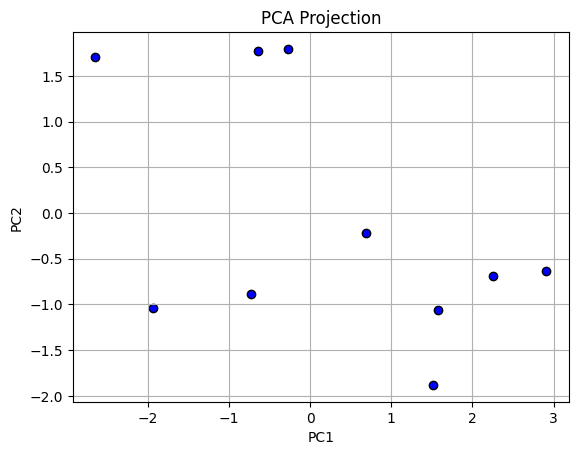

In [37]:
# Предположим, что у нас есть вот такой Matrix-класс
class Matrix:
    def __init__(self, rows, cols):
        self.rows = rows
        self.cols = cols
        self.data = [[0.0 for _ in range(cols)] for _ in range(rows)]

    def SetElement(self, row, col, value):
        self.data[row][col] = value

    def GetElement(self, row, col):
        return self.data[row][col]


from matplotlib.figure import Figure
import matplotlib.pyplot as plt

def plot_pca_projection(X_proj: 'Matrix') -> Figure:
    if X_proj.cols < 2:
        raise ValueError("Для визуализации требуется как минимум 2 главные компоненты")

    n = X_proj.rows
    x_vals = [X_proj.GetElement(i, 0) for i in range(n)]
    y_vals = [X_proj.GetElement(i, 1) for i in range(n)]

    fig, ax = plt.subplots()
    ax.scatter(x_vals, y_vals, c='blue', edgecolors='k', marker='o')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_title('PCA Projection')
    ax.grid(True)
    return fig

# пример на 10 точек
X_proj = Matrix(10, 2)
import random
for i in range(10):
    X_proj.SetElement(i, 0, random.uniform(-3, 3))  # PC1
    X_proj.SetElement(i, 1, random.uniform(-2, 2))  # PC2

# Визуализируем
fig = plot_pca_projection(X_proj)
plt.show()


## Вычислить среднеквадратическую ошибку восстановления данных

reconstruction_error считает MSE между элементами исходной и восстановленной матриц

In [38]:
from typing import List, Tuple

# Вычисление среднеквадратической ошибки восстановления данных
def reconstruction_error(X_orig: 'Matrix', X_recon: 'Matrix') -> float:

    if X_orig.rows != X_recon.rows or X_orig.cols != X_recon.cols:
        raise ValueError("Размеры матриц не совпадают")

    n, m = X_orig.rows, X_orig.cols
    total = 0.0

    for i in range(n):
        for j in range(m):
            x = X_orig.GetElement(i, j)
            y = X_recon.GetElement(i, j)
            total += (x - y) ** 2

    return total / (n * m)

In [41]:
# Создаём две простые матрицы вручную

X_orig = Matrix(2, 2)
X_orig.AddElement(0, 0, 1)
X_orig.AddElement(0, 1, 2)
X_orig.AddElement(1, 0, 3)
X_orig.AddElement(1, 1, 4)

X_recon = Matrix(2, 2)
X_recon.AddElement(0, 0, 0.9)
X_recon.AddElement(0, 1, 2.1)
X_recon.AddElement(1, 0, 2.9)
X_recon.AddElement(1, 1, 4.2)

# Вызываем функцию
mse = reconstruction_error(X_orig, X_recon)

# Печатаем результат
print(f"MSE восстановления: {mse:.6f}")


MSE восстановления: 0.017500
